In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('data_for_student_case.csv')
df.shape
# df

(290382, 17)

In [4]:
# Remove confused transaction 
df = df[df['simple_journal'] != 'Refused']
df.info()
print(df[df['simple_journal'] == 'Settled'].count()["simple_journal"])
print(df[df['simple_journal'] == 'Chargeback'].count()["simple_journal"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237036 entries, 0 to 290381
Data columns (total 17 columns):
txid                            237036 non-null int64
bookingdate                     237036 non-null object
issuercountrycode               237032 non-null object
txvariantcode                   237036 non-null object
bin                             237036 non-null float64
amount                          237036 non-null float64
currencycode                    237036 non-null object
shoppercountrycode              236694 non-null object
shopperinteraction              237036 non-null object
simple_journal                  237036 non-null object
cardverificationcodesupplied    223842 non-null object
cvcresponsecode                 237036 non-null int64
creationdate                    237036 non-null object
accountcode                     237036 non-null object
mail_id                         237036 non-null object
ip_id                           237036 non-null object
card_id  

In [5]:
# Convert bookingdate and creation date (string) into datetime 
cols = ['bookingdate', 'creationdate']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['creationdate'].describe()

count                  237036
unique                 232824
top       2015-08-22 10:12:01
freq                        6
first     2015-07-01 00:00:41
last      2015-10-31 23:59:12
Name: creationdate, dtype: object

Single variable exploration

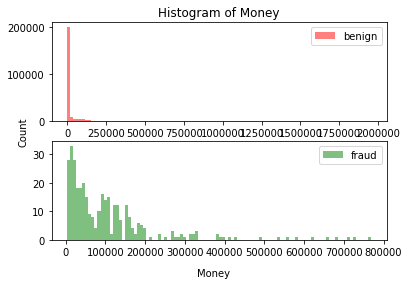

In [20]:
# Visualize money attribute
benign_data = df[df['simple_journal'] == 'Settled']
fraud_data = df[df['simple_journal'] == 'Chargeback']

f, axarr = plt.subplots(2)
kwargs = dict(alpha=0.5, bins=100)
axarr[0].hist(benign_data['amount'], **kwargs, color='r', label='benign')
axarr[0].legend()
axarr[1].hist(fraud_data['amount'], **kwargs, color='g', label='fraud')
axarr[1].legend()
f.text(0.5, 0.01, 'Money', ha='center', va='center')
f.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical')
axarr[0].set_title("Histogram of Money")
# f.autofmt_xdate()
plt.show()

Bivariate analysis

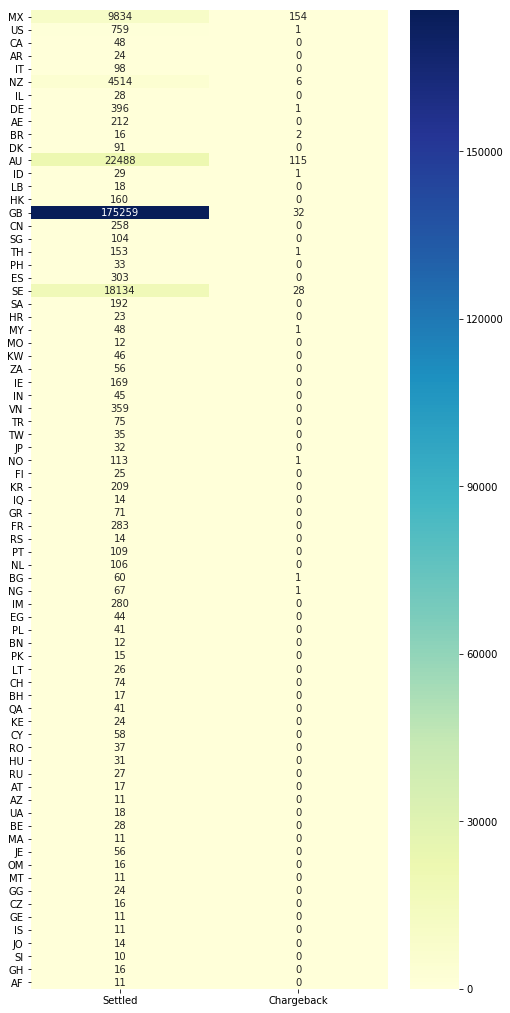

In [21]:
# country + simple_journal
country_list = df['shoppercountrycode'].unique()
result_list = ['Settled', 'Chargeback']
df_count = pd.DataFrame(index=country_list, columns=result_list, dtype='int64') # dataframe store counts
count = df.groupby(['shoppercountrycode','simple_journal']).size() # groupby count 

# Fill in 
for country in country_list:
    for result in result_list:
        if (country, result) in count:
            df_count.at[country, result] = int(count[country][result])
        else:
            df_count.at[country, result] = int(0)

# Drop countries which has less than 10 records             
df_count = df_count.drop(df_count[df_count['Settled'] + df_count['Chargeback'] < 10].index)
# print(df_count)

# Plot heatmap
plt.figure(figsize=(8,18))
sns.heatmap(df_count, annot=True, fmt='.0f',cmap="YlGnBu")

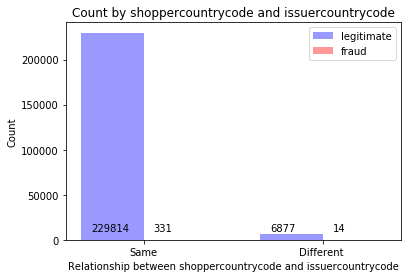

In [52]:
# relationship between shoppercountrycode and issuercountrycode
shopper_issue_same_benign = len(benign_data.loc[benign_data['shoppercountrycode'] == benign_data['issuercountrycode']])
shopper_issue_diff_benign = len(benign_data.loc[benign_data['shoppercountrycode'] != benign_data['issuercountrycode']])
shopper_issue_same_fraud = len(fraud_data.loc[fraud_data['shoppercountrycode'] == fraud_data['issuercountrycode']])
shopper_issue_diff_fraud = len(fraud_data.loc[fraud_data['shoppercountrycode'] != fraud_data['issuercountrycode']])

shopper_issue_benign = (shopper_issue_same_benign, shopper_issue_diff_benign)
shopper_issue_fraud = (shopper_issue_same_fraud, shopper_issue_diff_fraud)

fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.35

rects1 = ax.bar(index, shopper_issue_benign, bar_width,
                alpha=0.4, color='b', label='legitimate')

rects2 = ax.bar(index + bar_width, shopper_issue_fraud, bar_width,
                alpha=0.4, color='r',label='fraud')

ax.set_xlabel('Relationship between shoppercountrycode and issuercountrycode')
ax.set_ylabel('Count')
ax.set_title('Count by shoppercountrycode and issuercountrycode')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Same', 'Different '))
ax.legend()
# display value 
for i, v in enumerate(shopper_issue_benign):
    ax.text(i-.12, v/shopper_issue_benign[i] + 10000, str(shopper_issue_benign[i]), color='black')
for i, v in enumerate(shopper_issue_fraud):
    ax.text(i-.12 + bar_width, v/shopper_issue_fraud[i] + 10000, str(shopper_issue_fraud[i]), color='black')

plt.show()

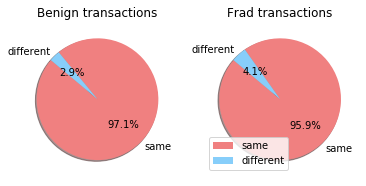

In [69]:
labels = ['same','different']
colors = ['lightcoral', 'lightskyblue']

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pie(shopper_issue_benign, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax1.set_title("Benign transactions")
ax2.pie(shopper_issue_fraud, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax2.set_title("Frad transactions")
ax2.legend()
plt.show()